In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_cora import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.node2vec import PositionalOmegaNode2Vec

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/cora/07-1-positional_omega_node2vec_cossim.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test, neg_edges_train =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device, get_neg_edges_train=True)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
pq_space = np.logspace(-1, 1, 5).round(2)
pq_space

array([ 0.1 ,  0.32,  1.  ,  3.16, 10.  ])

In [8]:
omega = PositionalOmegaNode2Vec(
                device,
                dataset,
                edge_index,
                data.num_nodes,
                1,
                1,
                run=0)

In [9]:
for run in range(5):
    for p in pq_space:
        for q in pq_space:
            omega = PositionalOmegaNode2Vec(
                device,
                'cora',
                edge_index,
                data.num_nodes,
                p,
                q,
                run=run)
            torch.cuda.empty_cache()
            omega.train(edge_index,
                        edges_val,
                        edges_test,
                        neg_edges_train,
                        neg_edges_val,
                        neg_edges_test,
                        edges_train_auc,
                        edges_val_auc,
                        edges_test_auc,
                        data.y)
            omega.discard_run_not_optimal_models()

## Results

### For a layer number

In [27]:
pq_space = np.logspace(-1, 1, 5).round(2)
param_grid = ParameterGrid({
    'p': pq_space,
    'q': pq_space,
})

In [28]:
chosen_param = param_grid[20]
chosen_param

{'q': 0.1, 'p': 10.0}

In [29]:
metrics = PositionalOmegaNode2Vec.read_metrics(
    dataset='cora',
    **chosen_param
)
metrics['node2vec_loss'] = metrics['node2vec_loss'].replace('None', np.nan).astype(float)
print(metrics.shape)
metrics.head()

(255, 11)


,p,q,run,epoch,node2vec_loss,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,10.0,0.1,0,0,NaN,1.388117,1.397463,1.398952,0.499329,0.492461,0.524092
1,10.0,0.1,0,10,4.724775,1.373510,1.381577,1.384903,0.511370,0.506660,0.540051
2,10.0,0.1,0,20,3.968988,1.359968,1.367226,1.371648,0.527810,0.520167,0.553897
3,10.0,0.1,0,30,3.398556,1.348255,1.354542,1.360020,0.549288,0.533947,0.562751
4,10.0,0.1,0,40,2.952135,1.338652,1.343760,1.350582,0.563643,0.542911,0.572659


### Sumarize metrics per epoch

In [30]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['epoch', 'node2vec_loss', 'loss_train', 'loss_val', 'loss_test',
       'auc_train', 'auc_val', 'auc_test'],
      dtype='object')

In [31]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [32]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,epoch_mean,epoch_std,node2vec_loss_mean,node2vec_loss_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,,,
0,0.0,0.0,-1.000000,0.000000,1.389525,0.005929,1.393393,0.005240,1.400047,0.004819,0.487185,0.019901,0.500045,0.015339,0.510115,0.020138
10,10.0,0.0,4.736153,0.012205,1.375206,0.006409,1.377374,0.005473,1.385431,0.004460,0.499245,0.020404,0.515284,0.015290,0.521989,0.021966
20,20.0,0.0,3.946122,0.020732,1.361837,0.006749,1.362808,0.005819,1.371666,0.004234,0.514804,0.020283,0.532186,0.016264,0.536626,0.021008
30,30.0,0.0,3.393952,0.012133,1.350439,0.006965,1.350557,0.005813,1.359791,0.003913,0.533247,0.022293,0.545473,0.016860,0.550506,0.018211
40,40.0,0.0,2.953501,0.003749,1.341137,0.007009,1.340774,0.005601,1.349999,0.003706,0.544683,0.025151,0.553749,0.017263,0.563103,0.017290


In [33]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,epoch_mean,epoch_std,node2vec_loss_mean,node2vec_loss_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,,,
60,60.0,0.0,2.334745,0.005837,1.326664,0.006806,1.326122,0.005329,1.334222,0.003296,0.546980,0.031886,0.561265,0.017980,0.572874,0.011572
50,50.0,0.0,2.611428,0.004020,1.333422,0.006935,1.332893,0.005494,1.341734,0.003487,0.547367,0.028590,0.559623,0.018729,0.570449,0.014459
70,70.0,0.0,2.114248,0.007063,1.320221,0.006583,1.319731,0.005076,1.327189,0.003082,0.545031,0.033279,0.559585,0.017098,0.572004,0.011216
500,500.0,0.0,0.853544,0.003144,1.094937,0.005185,1.100488,0.004383,1.097619,0.006103,0.576807,0.018368,0.555983,0.005555,0.563860,0.015637
80,80.0,0.0,1.915117,0.006877,1.313624,0.006333,1.313405,0.005029,1.319917,0.003046,0.541537,0.033319,0.555732,0.017733,0.568289,0.011945


/tmp/ipykernel_177697/778289093.py:10: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_177697/778289093.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_177697/778289093.py:37: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behav

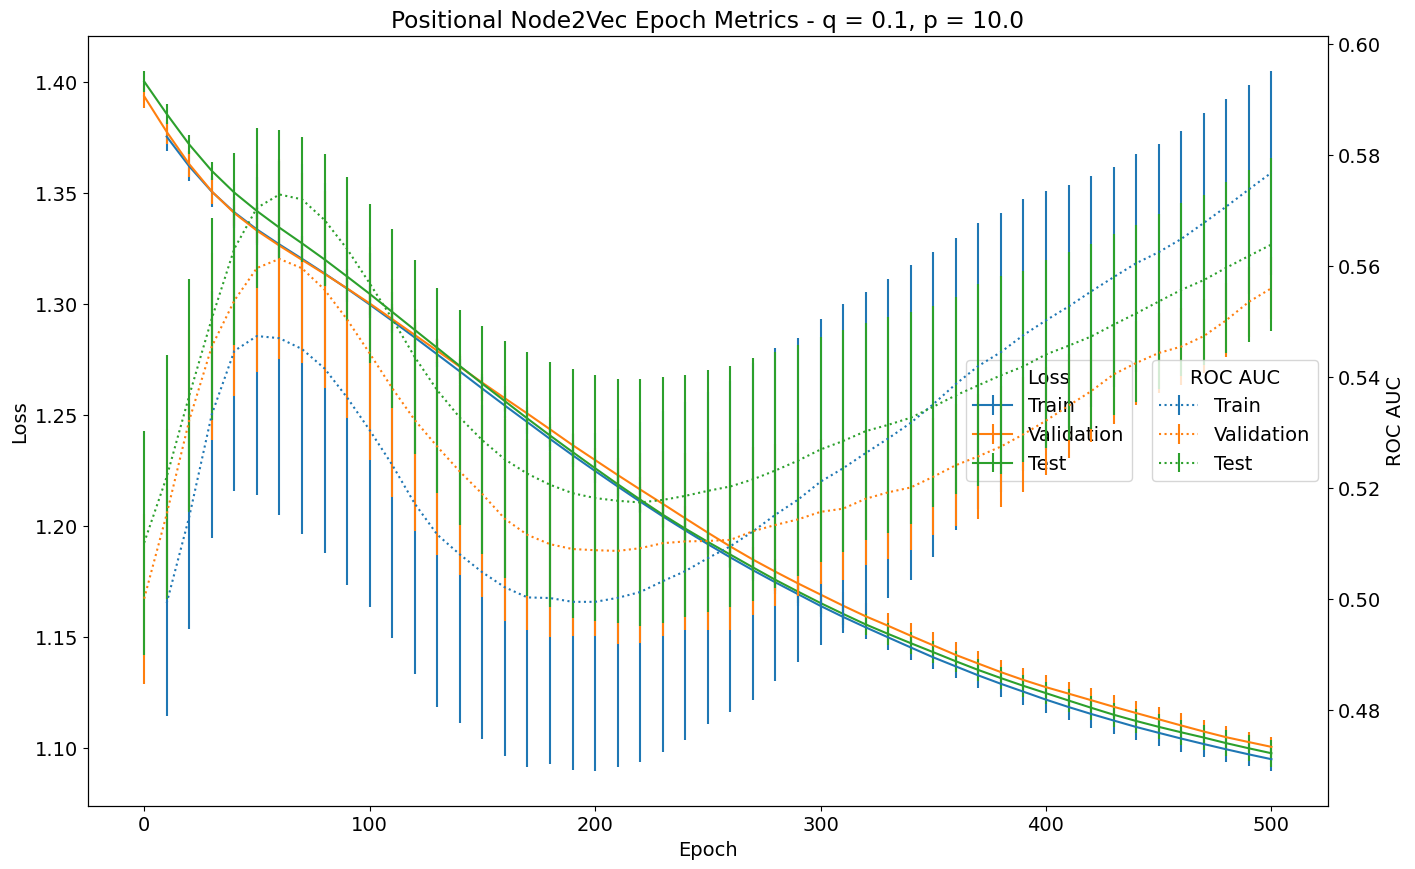

In [34]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

str_desc = ', '.join([f'{k} = {v}' for k, v in chosen_param.items()])

ax1.set_title(f'Positional Node2Vec Epoch Metrics - {str_desc}')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')


str_path_desc = '__'.join([f'{k}_{v}' for k, v in chosen_param.items()])
plt.savefig(f'reports/images/cora/positional_omega_node2vec_{str_path_desc}_cossim_training_metrics.pdf')

### Comparing Validation Performance for All Layer numbers

In [35]:
n_layers_list = range(1, 4)

In [36]:
tuple(param_grid[20].items())

(('q', 0.1), ('p', 10.0))

In [39]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}

full_metrics_list = []
for params in param_grid:
    param_tuple = tuple(params.items())
    metrics = PositionalOmegaNode2Vec.read_metrics(
        dataset='cora',
        **params
    )
    full_metrics_list.append(metrics)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    max_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[param_tuple] = auc_val
    mean_loss_val_dict[param_tuple] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[param_tuple] = auc_val
    std_loss_val_dict[param_tuple] = loss_val

full_metrics_df = pd.concat(full_metrics_list)

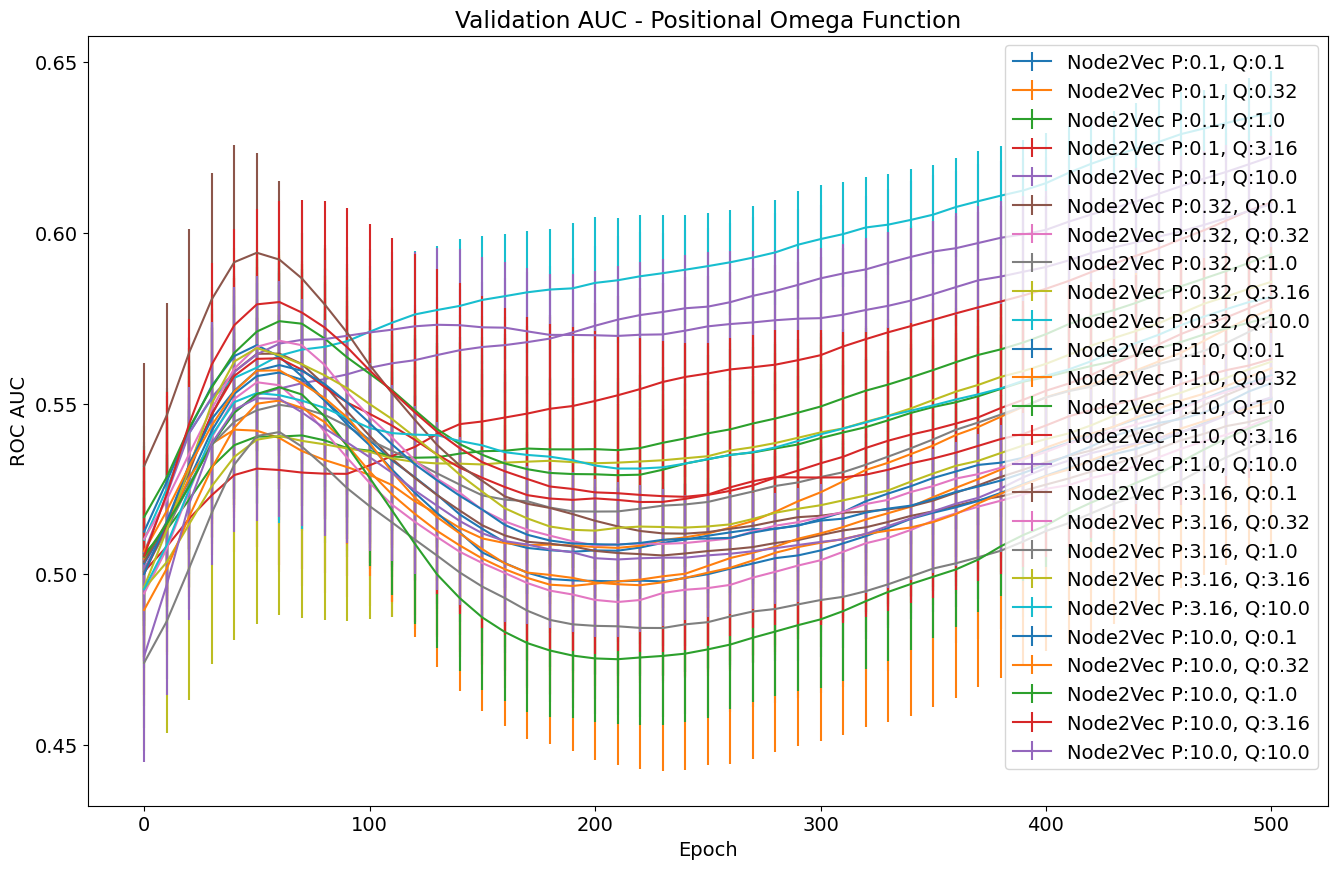

In [40]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Positional Omega Function')

for params in param_grid:
    param_tuple = tuple(params.items())
    ax1.errorbar(
        mean_auc_val_dict[param_tuple].index,
        mean_auc_val_dict[param_tuple],
        yerr=std_auc_val_dict[param_tuple],
        ls='-',
        label=f'Node2Vec P:{params["p"]}, Q:{params["q"]}')


# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

### Best AUC Heatmap

<AxesSubplot: xlabel='q', ylabel='p'>

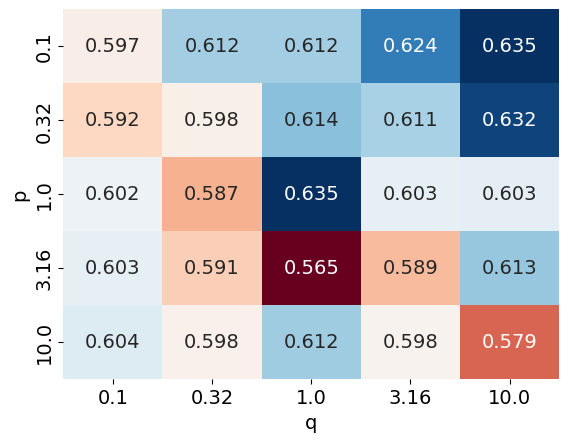

In [41]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_train'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

<AxesSubplot: xlabel='q', ylabel='p'>

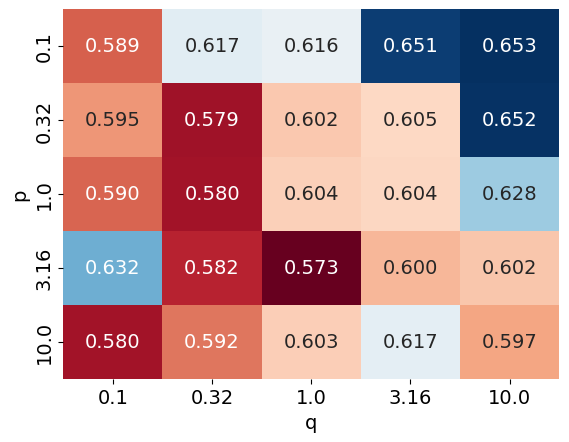

In [42]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

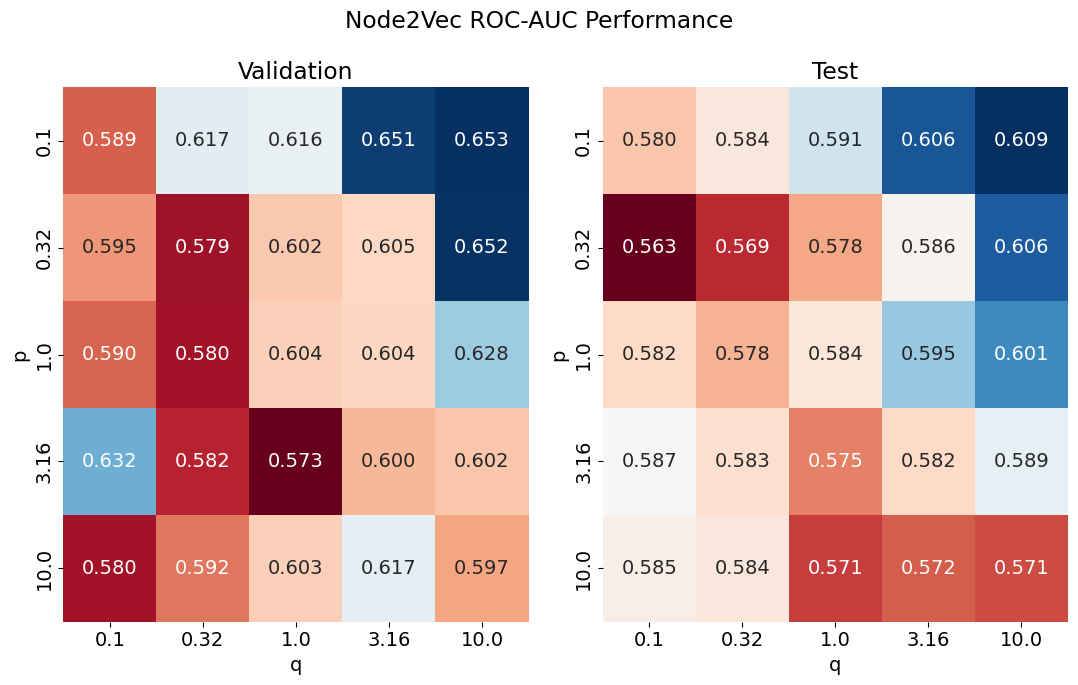

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))

fig.suptitle('Node2Vec ROC-AUC Performance')

sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax1
)

ax1.set_title('Validation')


sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_test'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax2,
)

ax2.set_title('Test')

plt.tight_layout()

plt.savefig(f'reports/images/cora/positional_omega_node2vec_rocauc_summary.pdf')

## Score Best model

In [44]:
best_model_metrics = full_metrics_df.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

p                               0.1
q                              10.0
run                               4
epoch                           500
node2vec_loss    0.7820274829864502
loss_train                 1.125533
loss_val                   1.097768
loss_test                  1.120077
auc_train                  0.634322
auc_val                    0.652757
auc_test                   0.598114
Name: 254, dtype: object

In [46]:
best_model_metrics.to_json('models/positional_omega_node2vec/cora/best_model_info.json')